# Imports

In [16]:
from sklearn.linear_model import LogisticRegression
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Constants

In [17]:
DATASET = "fantasy_reasoning"
MODEL_NAME = "gemma-2-2b"
DATA_DIR = f"./experimental_data/{MODEL_NAME}/{DATASET}/"
WEIGHTS_DIR = f"./weights/linear_analysis/{MODEL_NAME}/{DATASET}/"
TRAIN_SIZE = 0.8
TOP_K = 10  # Set to -1 to see every element
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data

Load data

In [18]:
acts_exp_resid = torch.load(DATA_DIR + "acts_exp_resid.pt", map_location=device)
acts_resid = torch.load(DATA_DIR + "acts_resid.pt", map_location=device)

C:\Users\wsr20\AppData\Local\Temp\ipykernel_17340\96380757.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  acts_exp_resid = torch.load(DATA_DIR + "acts_exp_resid.pt", ma

In [19]:
print(acts_exp_resid.shape)

torch.Size([201, 26, 2304])


Split data

In [20]:
X_train_index = int(TRAIN_SIZE * acts_exp_resid.shape[0])
X_train_exp_resid = acts_exp_resid[:X_train_index, :, :]
X_train_resid = acts_resid[:X_train_index, :, :]
X_test_exp_resid = acts_exp_resid[X_train_index:, :, :]
X_test_resid = acts_resid[X_train_index:, :, :]

In [21]:
print(X_train_resid.shape, X_test_resid.shape)

torch.Size([160, 26, 2304]) torch.Size([41, 26, 2304])


1 indicates CoT, 0 is Non-CoT

In [22]:
y_train_exp_resid = torch.ones(X_train_exp_resid.shape[0])
y_train_resid = torch.zeros(X_train_resid.shape[0])
y_test_exp_resid = torch.ones(X_test_exp_resid.shape[0])
y_test_resid = torch.zeros(X_test_resid.shape[0])

In [23]:
print(y_train_resid.shape, y_test_resid.shape)

torch.Size([160]) torch.Size([41])


Concatenate the data

In [24]:
X_train = torch.cat((X_train_exp_resid, X_train_resid), dim=0)
X_test = torch.cat((X_test_exp_resid, X_test_resid), dim=0)
y_train = torch.cat((y_train_exp_resid, y_train_resid), dim=0)
y_test = torch.cat((y_test_exp_resid, y_test_resid), dim=0)

In [25]:
print(X_train.shape, y_train.shape)

torch.Size([320, 26, 2304]) torch.Size([320])


# Initialize and train classifiers

In [26]:
classifiers = [LogisticRegression(fit_intercept=False)] * acts_resid.shape[1]

In [27]:
X_train, y_train, X_test, y_test = X_train.cpu().numpy(), y_train.cpu().numpy(), X_test.cpu().numpy(), y_test.cpu().numpy()
for i, classifier in enumerate(classifiers):
    classifier.fit(X_train[:, i, :], y_train)

# Evaluate classifiers

In [28]:
weights_list = []
accuracies = []
for i, classifier in enumerate(classifiers):
    y_pred = classifier.predict(X_test[:, i, :])
    print(f"layer {i}")
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    accuracies.append(accuracy)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", conf_matrix)
    
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:\n", class_report)

    weights = classifier.coef_
    print(f"Weights: {weights}")
    weights_list.append(weights)

    top_k = np.argsort(weights[0, :])[::-1][:TOP_K]
    print(f"Top k indeces: {top_k}")

    print("\n")

layer 0
Accuracy: 1.0
Confusion Matrix:
 [[41  0]
 [ 0 41]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        41
         1.0       1.00      1.00      1.00        41

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Weights: [[-0.00040262 -0.00112977 -0.0011051  ... -0.00107047  0.00148265
  -0.00164308]]
Top k indeces: [1393  689 1570 1824 2269 2251 1610  564 1413 2030]


layer 1
Accuracy: 1.0
Confusion Matrix:
 [[41  0]
 [ 0 41]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        41
         1.0       1.00      1.00      1.00        41

    accuracy                           1.00        82
   macro avg       1.00      1.00      1.00        82
weighted avg       1.00      1.00      1.00        82

Weights: [[-0.0004

Starting from layer 7 we are able to obtain perfect prediction. However, it seems like certain neurons are always activated.

# Save weights

In [29]:
for i, weights in enumerate(weights_list):
    weights = torch.tensor(weights)
    torch.save(weights, WEIGHTS_DIR + f"layer_{i}.pt")

# Plot Accuracy

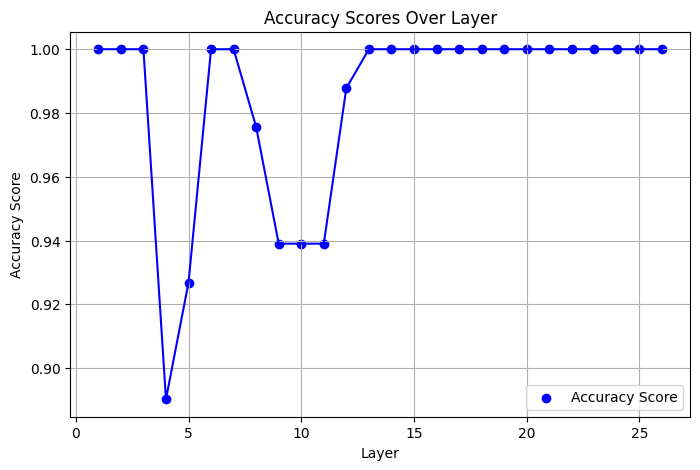

In [30]:
x_values = range(1, len(accuracies) + 1)
plt.figure(figsize=(8, 5))
plt.scatter(x_values, accuracies, color="blue", label="Accuracy Score")
plt.plot(x_values, accuracies, color="blue")

# Adding titles and labels
plt.title("Accuracy Scores Over Layer")
plt.xlabel("Layer")
plt.ylabel("Accuracy Score")
plt.grid(True)
plt.legend()
plt.savefig(f"./figs/{MODEL_NAME}/{DATASET}/{DATASET}_accuracy.png")
plt.show()